## Import functions

In [1]:
import sys
sys.path.append("/home/noa/Desktop/paper")
from agri_utilities import *
# from utilities.utils import *

<h1 style="color:green">1. Grassland Classification</h1>



In [2]:
# Threshold for absolute NDVI decreasing (NDVI(t-1)-NDVI(t))
decreasing_abs_th = 0.12

## Threshold for relative NDVI decreasing (slope)
decreasing_rate_th = -0.000001

## Threshold for relative NDVI increasing (slope)
increasing_rate_th =  0.05

import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import scipy.special as spec
import warnings
warnings.filterwarnings("ignore")

class Mowing_Detection:
    
    def __init__(self,model):
        
        self.model = model
        self.columns = ['mow_n','m1_dstart','m1_dend','m1_conf',
                        'm2_dstart','m2_dend','m2_conf',
                        'm3_dstart','m3_dend','m3_conf']
        self.InitialParameters = (65.,265.,0.2,0.9,0.05,0.05)       
        
    def predict(self,*args,**kwargs):
        
        if self.model == 1:
            return self.model_1(*args,**kwargs)
            
        elif self.model == 2:
            return self.model_2(*args,**kwargs)     
        else:
            return self.model_3(*args,**kwargs)
        
    def model_1(self,*args,**kwargs):
        df = args[0]
        try:
            th = kwargs['threshold']
        except:
            th = 0.2
        try:
            min_rate = kwargs['min_rate']
        except:
            min_rate = -0.000001
        columns = self.columns
        final_df = pd.DataFrame(data=np.zeros((df.shape[0],len(columns))),
                                index=df.index,columns=columns)
        for p in tqdm(range(df.shape[0])):
            df_temp = df.iloc[p,:].dropna()
            days = df_temp.index
            vi = df_temp.values
            mowing_events = []
            confidence = []
            flag = False
            for t in range(1,len(vi)):

                if flag:
                    flag = False
                    continue

                d = days[t]-days[t-1]
                d = d.days
                if np.isnan(vi[t]):
                    continue
                if (vi[t]<vi[t-1]-th) and (vi[t-1]-vi[t] > d*min_rate):
                    mowing_events.append((days[t-1],days[t]))
                    confidence.append(vi[t-1]-vi[t]-th)
                    flag = True


            if mowing_events:
                args = np.array(sorted(np.argsort(confidence)[::-1][:3]))
                mowing_events = [mowing_events[n] for n in args]
                final_df.iloc[p,0] = len(args)
                final_df.iloc[p,1:3*len(args):3] = [m[0] for m in mowing_events]
                final_df.iloc[p,2:1+3*len(args):3] = [m[1] for m in mowing_events]
                confidence = np.array(confidence)
                final_df.iloc[p,3:2+3*len(args):3] = confidence[args]
        return final_df
        
        
    def model_2(self,*args,**kwargs):
        
            vi = args[0]
            vi_old = args[1]
            try:
                k = kwargs['k']
            except:
                k = 10
            self.InitialParameters, sigma_t = optical_cloud_fit(vi_old,self.InitialParameters)
            return  VI_overcast_detection(vi,sigma_t,self.InitialParameters,k=k)
       
        
    def model_3(self,coherence):
          
            columns = self.columns
            final_df = pd.DataFrame(data=np.zeros((coherence.shape[0],len(columns))),
                        index=coherence.index,columns=columns)
            
            for p in range(coherence.shape[0]):
 
                days = coherence.iloc[p,:].index
                c = coherence.iloc[p,:].values
                mowing_events = []
                confidence = []
                pfa = 3.0e-7
                kappa = np.sqrt(2)*spec.erfinv(1.-2.*pfa)
                for t in range(5,len(c)):
                    a,b = np.polyfit(np.arange(5),c[t-5:t],1)
                    sigma = np.std(np.abs(c[t-5:t]-np.array([a*i+b for i in np.arange(5)]))/c[t-5:t])
                    pred = a*5+b
                    if (c[t]-pred>kappa*sigma):
                        mowing_events.append((days[t-1],days[t]))
                        confidence.append(c[t]-pred)
                    
                    
                if mowing_events:
                    args = np.argsort(confidence)[::-1][:3]
                    mowing_events = [mowing_events[n] for n in args]
                    final_df.iloc[p,0] = len(args)
                    final_df.iloc[p,1:3*len(args):3] = [m[0] for m in mowing_events]
                    final_df.iloc[p,2:1+3*len(args):3] = [m[1] for m in mowing_events]
                    final_df.iloc[p,3:2+3*len(args):3] = np.sort(confidence)[::-1][:len(args)]
            return final_df
                        
def f(t,t_s,t_a,vi_w,vi_m,m_a,m_s):
    """
    double-logistic function
    t_s: increasing inflection point (spring date)
    t_a: decreasing inflection point (autumn date)
    vi_w: winter (minimum) value
    vi_m: maximum value
    m_a: rate of decrease at the t_a descending inflection point
    m_s: rate of increase at the t_s increasing inflection point
    """
    return vi_w + (vi_m-vi_w)*(1./(1.+np.exp(-m_s*(t - t_s))) + 1./(1.+np.exp(m_a*(t-t_a))) - 1.)

def optical_cloud_fit(df,InitialParameters):
     
    n_ti = [np.zeros(366) for _ in range(len(df.columns.year.unique()))]  #number of samples VIs at the time t
    p95_ti = [np.zeros(366) for _ in range(len(df.columns.year.unique()))]  #95th percentile of the VIs at the time t
    m_ti = [np.zeros(366) for _ in range(len(df.columns.year.unique()))]  #mean of the VIs at the time t
    sigma_ti = [np.zeros(366) for _ in range(len(df.columns.year.unique()))] #standard deviation of the VIs at the time t
    for y,year in enumerate(df.columns.year.unique()):
        temp = df.loc[:,df.columns.year == year]
        temp = temp.T.resample('D').asfreq().T
        temp.columns = temp.columns.dayofyear
        n_ti[y][temp.columns[0]-1:temp.columns[-1]] = temp.count(axis=0).values #number of samples retrieved for each past year
        p95_ti[y][temp.columns[0]-1:temp.columns[-1]] = temp.quantile(q=0.95,axis=0).values #95th percentile retrieved for each past year
        m_ti[y][temp.columns[0]-1:temp.columns[-1]] = temp.mean(axis=0).values #mean retrieved for each past year
        sigma_ti[y][temp.columns[0]-1:temp.columns[-1]] = temp.std(axis=0).values
    n_t = np.zeros(366)
    for i in range(len(n_t)):
        for j in range(len(n_ti)):
            n_t[i] += n_ti[j][i]
    p95_t = np.zeros(366)
    for i in range(len(p95_t)):
        if n_t[i] != 0.0:
            for j in range(len(p95_ti)):
                if n_ti[j][i] != 0.0:
                    p95_t[i] += (n_ti[j][i]/n_t[i])*p95_ti[j][i]
    m_t = np.zeros(366)
    for i in range(len(m_t)):
        if n_t[i] != 0.0:
            for j in range(len(m_ti)):
                if n_ti[j][i] != 0.0:
                    m_t[i] += (n_ti[j][i]/n_t[i])*m_ti[j][i]
    sigma_t_1 = np.zeros(366)
    sigma_t_2 = np.zeros(366)
    sigma_t = np.zeros(366)
    for i in range(len(n_t)):
        for j in range(len(n_ti)):
            if n_ti[j][i] != 0.0:
                sigma_t_1[i] += ((n_ti[j][i]-1)*pow(sigma_ti[j][i],2))
                sigma_t_2[i] += n_ti[j][i]-1
            sigma_t[i] = np.sqrt(sigma_t_1[i]/sigma_t_2[i])
    arr = m_t[m_t>0]
    #ci = (arr.mean()-1.96*arr.std()/np.sqrt(len(arr)-1),arr.mean()+1.96*arr.std()/np.sqrt(len(arr)-1))
    ci = st.norm(*st.norm.fit(arr)).interval(0.95) 
    to_discard = np.where(m_t<ci[0])
    doy = np.delete(np.arange(366)+1,to_discard)
    p95_t = np.delete(p95_t,to_discard)
    sigma_t[to_discard] = np.nanmean(np.delete(sigma_t,to_discard))
    sigma_t[np.isnan(sigma_t)==True] = sigma_t[np.isnan(sigma_t)==False].mean()
    (t_s,t_a,vi_w,vi_m,m_a,m_s), _ = opt.curve_fit(f,doy,p95_t,InitialParameters,method='trf',
                                                   bounds=((60,250,0.1,0.7,0.03,0.03), (80.,280.,0.3,1.0,0.15,0.15)),
                                                   maxfev=10000)
    return (t_s,t_a,vi_w,vi_m,m_a,m_s),sigma_t

def VI_overcast_detection(df,sigma_t,initial_params,k=10):
    
    
    columns = ['mow_n','m1_dstart','m1_dend','m1_conf',
                        'm2_dstart','m2_dend','m2_conf',
                        'm3_dstart','m3_dend','m3_conf']
    final_df = pd.DataFrame(data=np.zeros((df.shape[0],len(columns))),index=df.index,columns=columns)
    
    for p in tqdm(range(df.shape[0])):
        t_s,t_a,vi_w,vi_m,m_a,m_s = initial_params
        vi = df.iloc[p,:].copy()
        vi.dropna(inplace=True)
        days = vi.index
        vi = vi.values
        events = np.zeros(len(vi))
        conf = np.zeros(len(vi))
        mowing_events = []
        for t in range(len(vi)):                
            d = f(days[t].dayofyear,t_s,t_a,vi_w,vi_m,m_a,m_s)-vi[t]
            if d > k*sigma_t[days[t].dayofyear-1] and t>0:
                events[t] = 1
                conf[t] = d
                mowing_events.append((days[t-1],days[t]))
            if (vi[t] > f(days[t].dayofyear,t_s,t_a,vi_w,vi_m,m_a,m_s)) or (t==0) or (events[t]==1):
                new_t = days.dayofyear
                new_tt = days
                new_y = np.array(f(new_t,t_s,t_a,vi_w,vi_m,m_a,m_s))
                weights = np.ones(len(days))
                if events[t]==1:
                    if t<len(days)-1:
                        new_y[t+1] = vi[t+1]
                        weights[t+1] = 0.1
                        weights[:1] = 0.1
                        if t+1 < len(days)-5:
                            weights[-2:] = 0.1
                else:
                    new_y[t] = vi[t]
                    weights[t] = 0.1
                    weights[:1] = 0.1
                    if t < len(days)-5:
                        weights[-2:] = 0.1
                    
                (t_s,t_a,vi_w,vi_m,m_a,m_s), _ = opt.curve_fit(f,new_t,new_y,initial_params,method='trf',
                                                               bounds=((60,250,0.1,0.7,0.03,0.03), 
                                                                       (80.,280.,0.3,1.0,0.15,0.15)),
                                                                       sigma=weights,maxfev=10000)
       
        confidence = conf[conf>0]       
        args = np.argsort(confidence)[::-1][:3]
        mowing_events = [mowing_events[n] for n in args]
        final_df.iloc[p,0] = len(args)
        final_df.iloc[p,1:3*len(args):3] = [m[0] for m in mowing_events]
        final_df.iloc[p,2:1+3*len(args):3] = [m[1] for m in mowing_events]
        final_df.iloc[p,3:2+3*len(args):3] = np.sort(confidence)[::-1][:len(args)]
           
    return final_df

In [3]:
# Read all files      
import glob
s2_files = glob.glob("/data2/netherlands/fs2017*.csv")

# Sort based on date
s2_files = sorted(s2_files, key = lambda x: datetime.strptime(x.split('/')[-1].split('.')[0][2:], '%Y-%m-%d'))


# Merge dataframes for each data in one, for all bands (S2 and S1)
dfs = []
for i,f in enumerate(s2_files):
    if i == 0:
        dfs.append(pd.read_csv(f))
    else:
        dfs.append(pd.read_csv(f).iloc[:,1:])

data = pd.concat(dfs, axis=1)
del dfs
data = data.set_index("id")

# Keep only mean. If you want more use '|' as separator among all statistics. e.g. data.filter(regex = 'mean|std|median')
data = data.filter(regex = 'mean')

In [4]:
# Keep S2 data
data = data[[x for x in data.columns if pd.to_datetime(x.split('_')[-1]) < pd.to_datetime('2017-11-01')]]

# Load masks (this file contains the cloud free pixels for each parcel for each date.)
masks = pd.read_csv('/data2/netherlands/masks2017.csv')
masks = masks.set_index('id')
masks = pd.concat([masks for _ in range(13)], axis = 1)

# Keep parcels with more than 85% cloud free pixels (or less than 15% cloud coverage)
masks.columns = data.columns
data_filt = data[(masks > 0.95)]


# Fill NaN with linear interpolation. There is also the capability of creating fixed time fetures 
# by setting the atribbute fixed_time = n, where n corresponds to the # of days for the time step.
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'ndvi', 'ndwi', 'psri']
data_filt = daily_fs(data_filt, year='2017', start_doy=83, end_doy=300, bandnames=bands, s1 = False)
data = daily_fs(data, year='2017', start_doy=83, end_doy=300, bandnames=bands, s1 = False)

data = data.dropna()
data_filt = data_filt.dropna()
# Save for later
# data.to_csv('/data2/netherlands/s2_s1_fs_filledNA.csv')

100%|██████████| 13/13 [02:43<00:00, 12.60s/it]


In [5]:
import geopandas
lpis = geopandas.read_file("/data2/netherlands/shapefiles/lpis_dandrimond_3857.shp")
lpis = lpis.set_index("id")
lpis.columns = ['CAT_GEWASCATEGORIE', 'GWS_GEWASCODE','GEOMETRIE_Length','GEOMETRIE_Area','GWS_GEWAS','_mean','_27_meanme','geometry']
lpis.GWS_GEWASCODE = lpis.GWS_GEWASCODE.astype(int)

grassland_indices = lpis.loc[lpis.GWS_GEWASCODE.isin([265,331,336])].index

data = data[data.index.isin(grassland_indices)]
data_filt = data_filt[data_filt.index.isin(grassland_indices)]

In [6]:
grassland_ndvi = data.filter(regex = 'ndvi')
grassland_ndvi.columns = grassland_ndvi.columns.map(lambda x: pd.to_datetime(x.split("_")[-1]))

grassland_ndvi_filt = data_filt.filter(regex = 'ndvi')
grassland_ndvi_filt.columns = grassland_ndvi_filt.columns.map(lambda x: pd.to_datetime(x.split("_")[-1]))

cloud_cov = grassland_ndvi_filt.isna().sum()/len(grassland_ndvi_filt)
grassland_ndvi_filt = grassland_ndvi_filt[cloud_cov[cloud_cov < 0.89].index]

grassland_ndvi_filt = grassland_ndvi_filt[grassland_ndvi_filt.isna().sum(axis = 1) < 20]

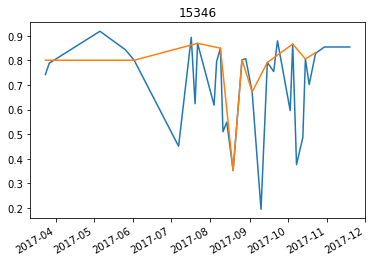

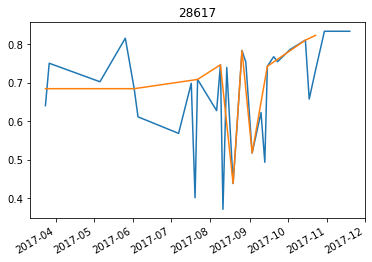

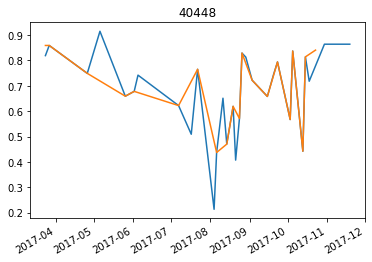

In [7]:
import random
samples = sorted(random.sample(list(grassland_ndvi_filt.index), 3))
for ii in samples:
    grassland_ndvi.loc[ii,:].plot()
    grassland_ndvi_filt.loc[ii,:].dropna().plot()
    plt.title(ii)
    plt.show()

In [8]:
filename = '/data2/netherlands/shapefiles/lpis_dandrimond_3857.shp'
geometries, ids = read_shapefile(shape_file = filename, selected_ids = samples)

In [9]:
MD = Mowing_Detection(1)
results = MD.predict(grassland_ndvi_filt,threshold=0.1,min_rate=0.005)

results.insert(0,'id',grassland_ndvi_filt.index)
results = results.set_index('id')



100%|██████████| 10141/10141 [01:24<00:00, 120.69it/s]


In [10]:
results.mow_n.value_counts()


3.0    6417
2.0    1485
1.0    1318
0.0     921
Name: mow_n, dtype: int64

In [11]:
results.to_csv("/data2/dataCAP/mowing_events.csv")

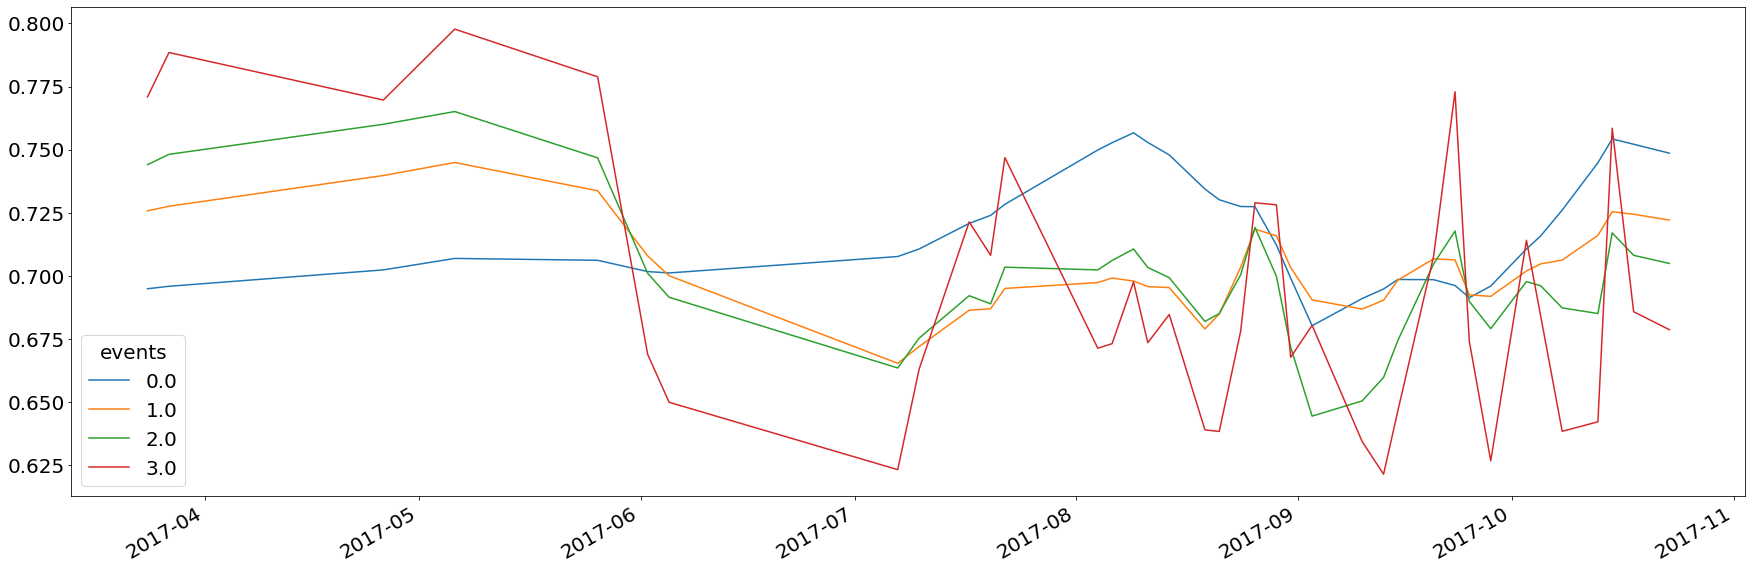

In [21]:
ax = results.join(grassland_ndvi_filt, how = 'inner').groupby('mow_n').mean().iloc[:,3:].T.plot(legend = True,figsize = (30,10))
ax.xaxis.set_tick_params(labelsize=20, which = 'both')
ax.yaxis.set_tick_params(labelsize=20, which = 'both')
ax.legend(title = 'events', fontsize=20, title_fontsize = 20)

In [73]:
grassland_ndvi_filt.head()

,2017-03-24,2017-03-27,2017-04-26,2017-05-06,2017-05-26,2017-06-02,2017-06-05,2017-07-07,2017-07-10,2017-07-17,...,2017-09-23,2017-09-25,2017-09-28,2017-10-03,2017-10-05,2017-10-08,2017-10-13,2017-10-15,2017-10-18,2017-10-23
id,,,,,,,,,,,,,,,,,,,,,
1,0.527,0.527000,0.527000,0.550333,0.597,0.613333,0.620333,0.695000,0.702000,0.718333,...,0.614800,0.631000,0.655300,0.695800,0.712000,0.736300,0.776800,0.793000,0.7936,0.794600
8,0.597,0.597000,0.597000,0.597000,0.597,0.597000,0.612180,0.774100,0.789280,0.824700,...,0.643857,0.661143,0.687071,0.730286,0.747571,0.773500,0.816714,0.834000,0.8344,0.835067
12,0.701,0.701000,0.701000,0.701000,0.701,0.701000,0.704540,0.742300,0.745840,0.754100,...,0.507524,0.522476,0.544905,0.582286,0.597238,0.619667,0.657048,0.672000,0.6650,0.653333
16,0.803,0.797628,0.743907,0.726000,0.664,0.642300,0.633000,0.728238,0.737167,0.758000,...,0.645132,0.639921,0.632105,0.619079,0.613868,0.606053,0.593026,0.587816,0.5800,0.580000
64,0.842,0.842000,0.831000,0.730333,0.529,0.502000,0.518020,0.688900,0.704920,0.742300,...,0.923000,0.909833,0.890083,0.857167,0.844000,0.848500,0.856000,0.859000,0.8065,0.719000


<h1 style="color:green">2. Visual inspection of flagged parcels</h1>



--------------------------------------------------------------------
-------------------------- parcel 43438 -----------------------------
-------------------------------------------------------------------


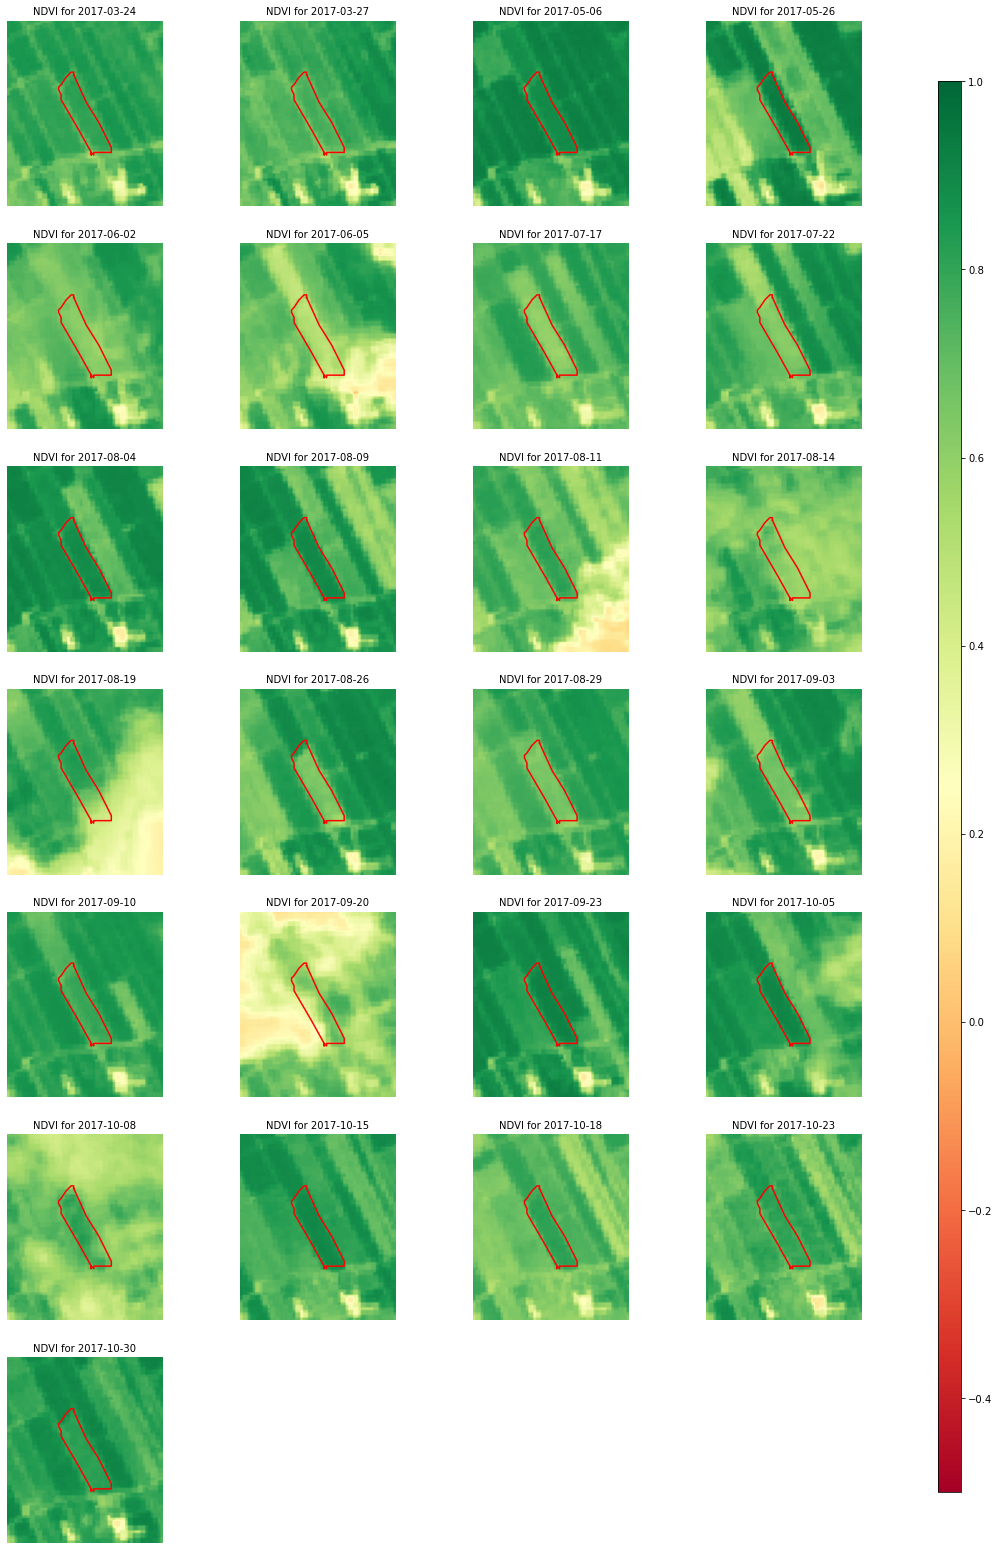

In [27]:
import random

samples = random.sample(list(results.index), 3)
filename = '/data2/netherlands/shapefiles/lpis_dandrimond_3857.shp'
# retrieve the geometries
geometries, ids = read_shapefile(shape_file = filename,selected_ids = samples)
plot_index_multiple_parcels([geometries[2]], [ids[2]], index = 'ndvi', start_time = '2017-03-01', end_time = '2017-11-01',
                      cloud_free_percentage = 20, cols = 4, buffer = 200)

# Mapillary Streel-Level image

In [28]:
import geopandas
from deep_translator import GoogleTranslator
import pandas_bokeh
from IPython.display import Image
from IPython.core.display import HTML 
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import bokeh.io
from bokeh.io import export_png
import requests

bokeh.io.reset_output()
bokeh.io.output_notebook()


Loading BokehJS ...

In [29]:
# Load the information about the Mapillary Street Level Images.
gdp_aoi = geopandas.read_file('/data2/netherlands/shapefiles/lpis_dandrimond_3857.shp')
gdp_aoi = gdp_aoi.to_crs("EPSG:4326") 
strlev = geopandas.read_file('/data2/netherlands/Mapillary/streetLevel2017.geojson')

english = {x:GoogleTranslator(source='nl', target='en').translate(x) for x in strlev.cropType_left.unique() if not x is None }
strlev['cropType_left'] = strlev['cropType_left'].map(english)
english = {x:GoogleTranslator(source='nl', target='en').translate(x) for x in strlev.cropType_right.unique() if not x is None }
strlev['cropType_right'] = strlev['cropType_right'].map(english)

In [ ]:
results.to_csv("/data2/dataCAP/mowing_events.csv")

In [71]:
# Example of a 
from bokeh.io import export_png
access_token = 'MLY|4072873196100565|866bc31a02c835fe90392586268f8300'
header = {'Authorization': 'OAuth {}'.format(access_token)}

test_parcel = 37659
    
print("------------------------------------------------")
print("---------------- Parcel {:5d} ------------------".format(test_parcel))
print("Mowing events: \033[1m \033[92m {} \033[0m ".format(int(results.loc[test_parcel, 'mow_n'])))
for i, row in strlev.loc[strlev.parcel_left == test_parcel].iterrows():
    url = 'https://graph.mapillary.com/{}?fields=thumb_2048_url'.format(row.id)
    r = requests.get(url, headers=header)
    dd = r.json()
    url = dd['thumb_2048_url']
    print("----------------  {}  ------------------".format(row.captured_at.split('T')[0]))
    display(Image(url=url))
    figure = strlev.iloc[[i]].plot_bokeh(show_figure=False, color = 'red', size=10, legend='Street level image')
    gdp_aoi.loc[gdp_aoi.id == row.parcel_left,['geometry']].plot_bokeh(figure = figure, legend='parcel')


------------------------------------------------
---------------- Parcel 37659 ------------------
Mowing events:   3  
----------------  2017-07-05  ------------------


----------------  2017-07-05  ------------------


----------------  2017-05-25  ------------------


----------------  2017-05-25  ------------------


----------------  2017-05-25  ------------------


----------------  2017-05-25  ------------------


----------------  2017-07-05  ------------------


----------------  2017-07-05  ------------------


----------------  2017-05-25  ------------------


----------------  2017-07-05  ------------------
